In [2]:
from __future__ import absolute_import

import sys
sys.path.append("../lib")
import pandas as pd
import matplotlib.pyplot as plt
from database import Database, Result

In [3]:
a = """
sdf {aval}
""".format(**{"aval":"hello"})
print(a)


sdf hello



In [4]:
db = Database()

def runTimes(start_time, end_time, db):
    times = {
            "starttime": start_time,
            "endtime": end_time
            }

    sql = """
    select 
    a.job_id, a.starttime as mrbayes_starttime, a.timestamp as mrbayes_timestamp, 
    b.starttime as clustalo_starttime, b.timestamp as clustalo_timestamp,
    TIMESTAMPDIFF(SECOND, a.starttime, a.timestamp) as mrbayes_time,
    TIMESTAMPDIFF(SECOND, b.starttime, b.timestamp) as clustalo_time
    from (select * from results 
          where prog='mrbayes' and starttime > '{starttime}' and timestamp < '{endtime}'
          ) a 
    join (select * from results 
          where prog='clustalo' and starttime > '{starttime}' and timestamp < '{endtime}'
          ) b 
    on a.job_id = b.job_id 
    order by a.timestamp desc
    """.format(**times)

    return pd.read_sql_query(sql, db.conn)


# rq = {"order":"squamata","data.dwc:associatedSequences": {"type":"exists"}}
# limit = 30
# 4 sequences
seq_4 = runTimes("2015-12-09 00:21:00", "2015-12-09 00:28:00", db)
# rq = {"order":"squamata","data.dwc:associatedSequences": {"type":"exists"}}
# limit = 100
# 5 sequences
seq_5 = runTimes("2015-12-09 00:44:15", "2015-12-09 00:46:30", db)
# rq = {"order":"squamata","data.dwc:associatedSequences": {"type":"exists"}}
# limit = 1000
# 6 sequences
seq_6 = runTimes("2015-12-09 01:00:00", "2015-12-09 01:03:00", db)
# rq = {"order":"squamata","data.dwc:associatedSequences": {"type":"exists"}}
# limit = 1000
# 7 sequences
seq_7 = runTimes("2015-12-09 01:05:00", "2015-12-09 01:09:00", db)
# rq = {"order":"squamata","data.dwc:associatedSequences": {"type":"exists"}}
# limit = 1000
# 8 sequences
seq_8 = runTimes("2015-12-09 01:14:00", "2015-12-09 01:17:00", db)
# rq = {"order":"squamata","data.dwc:associatedSequences": {"type":"exists"}}
# limit = 1000
# 16 sequences
seq_16 = runTimes("2015-12-09 01:44:00", "2015-12-09 01:50:00", db)
# rq = {"order":"squamata","data.dwc:associatedSequences": {"type":"exists"}}
# limit = 1000
# 16 sequences
seq_32 = runTimes("2015-12-09 06:30:00", "2015-12-09 06:40:00", db)


In [5]:
# the slices above need to be averaged together in to a new df
df = pd.DataFrame()
#df["seq_4_mrbayes"]
mean_clustalo = [seq_4["clustalo_time"].mean(), seq_5["clustalo_time"].mean(),
                seq_6["clustalo_time"].mean(), seq_7["clustalo_time"].mean(),
                seq_8["clustalo_time"].mean(), seq_16["clustalo_time"].mean(),
                seq_32["clustalo_time"].mean()]
mean_mrbayes = [seq_4["mrbayes_time"].mean(), seq_5["mrbayes_time"].mean(),
               seq_6["mrbayes_time"].mean(), seq_7["mrbayes_time"].mean(),
               seq_8["mrbayes_time"].mean(), seq_16["mrbayes_time"].mean(),
               seq_32["mrbayes_time"].mean()]
df["labels"] = ["4", "5", "6", "7", "8", "16", "32"]
df["mean_clustalo"] = mean_clustalo
df["mean_mrbayes"] = mean_mrbayes
#print df

(0.625, 8.125)

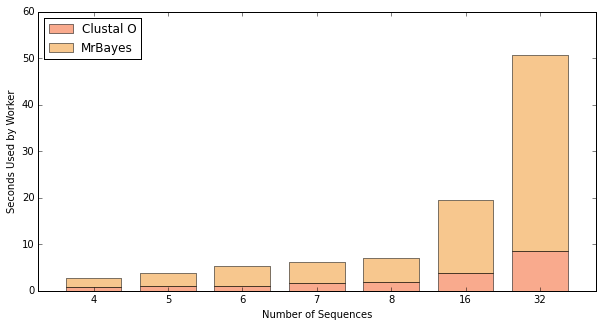

In [6]:
%matplotlib inline
#http://chrisalbon.com/python/matplotlib_stacked_bar_plot.html
f, ax1 = plt.subplots(1, figsize=(10,5))
bar_width = 0.75
bar_l = [i+1 for i in range(len(df['labels']))]
tick_pos = [i+(bar_width/2) for i in bar_l]
ax1.bar(bar_l,
        # using the pre_score data
        df['mean_clustalo'],
        # set the width
        width=bar_width,
        # with the label pre score
        label='Clustal O',
        # with alpha 0.5
        alpha=0.5,
        # with color
        color='#F4561D')
# Create a bar plot, in position bar_1
ax1.bar(bar_l,
        # using the mid_score data
        df['mean_mrbayes'],
        # set the width
        width=bar_width,
        # with pre_score on the bottom
        bottom=df['mean_clustalo'],
        # with the label mid score
        label='MrBayes',
        # with alpha 0.5
        alpha=0.5,
        # with color
        color='#F1911E')
plt.xticks(tick_pos, df['labels'])
ax1.set_ylabel("Seconds Used by Worker")
ax1.set_xlabel("Number of Sequences")
plt.legend(loc='upper left')
plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])